In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2


In [50]:
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [51]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)
df.head

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


<bound method NDFrame.head of         userId  movieId  rating   timestamp  user  movie
0            1        1     4.0   964982703     0      0
1            1        3     4.0   964981247     0      1
2            1        6     4.0   964982224     0      2
3            1       47     5.0   964983815     0      3
4            1       50     5.0   964982931     0      4
...        ...      ...     ...         ...   ...    ...
100831     610   166534     4.0  1493848402   609   3120
100832     610   168248     5.0  1493850091   609   2035
100833     610   168250     5.0  1494273047   609   3121
100834     610   168252     5.0  1493846352   609   1392
100835     610   170875     3.0  1493846415   609   2873

[100836 rows x 6 columns]>

In [57]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)
x_train_array = [x_train[:, 0], x_train[:, 1]]
x_val_array = [x_val[:, 0], x_val[:, 1]]

AttributeError: 'list' object has no attribute 'shape'

In [53]:
EMBEDDING_SIZE = 50
dropoutVal = 0.1
method = 'dot'  #'dense'

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderNet(num_users, num_movies, embedding_size, method):
    user = Input(shape=(1,))
    user_embedding = EmbeddingLayer(num_users, embedding_size)(user)
    user_bias = EmbeddingLayer(num_users, 1)(user)
    
    movie = Input(shape=(1,))
    movie_embedding = EmbeddingLayer(num_movies, embedding_size)(movie)
    movie_bias = EmbeddingLayer(num_movies, 1)(movie)

    if method=='dot':
    #########################Method 1: Dot Product##################################
        #Dot product of user embedding and movie embedding

        # Add all the components (including bias)

    #########################Method 2: Dense Layer##################################
    else:
        #Concatenate all embeddings and bias
        
        #Drop out, and dense layers

    ############################################################################################
    x = Dense(1,activation='sigmoid')(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE, method)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 50)        30500       input_12[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 50)        486200      input_13[0][0]                   
____________________________________________________________________________________________

In [54]:
history = model.fit(
    x=x_train_array,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val_array, y_val),
)

c:\programdata\anaconda3.0\envs\tf_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 13s 146us/step - loss: 0.6243 - val_loss: 0.5991
Epoch 2/5
90752/90752 [==============================] - 13s 143us/step - loss: 0.5789 - val_loss: 0.5964
Epoch 3/5
90752/90752 [==============================] - 13s 143us/step - loss: 0.5493 - val_loss: 0.6036
Epoch 4/5
90752/90752 [==============================] - 13s 143us/step - loss: 0.5325 - val_loss: 0.6113
Epoch 5/5
90752/90752 [==============================] - 13s 143us/step - loss: 0.5245 - val_loss: 0.6193


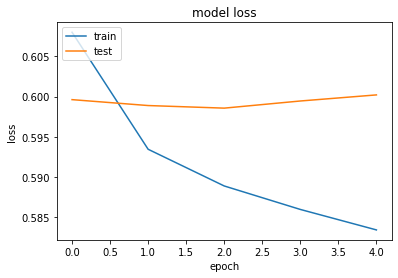

In [46]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [60]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_movie_array = [user_movie_array[:, 0], user_movie_array[:, 1]]
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [61]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 141
Movies with high ratings from user
--------------------------------
Bull Durham (1988) : Comedy|Drama|Romance
Stranger than Fiction (2006) : Comedy|Drama|Fantasy|Romance
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Django Unchained (2012) : Action|Drama|Western
Grand Budapest Hotel, The (2014) : Comedy|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Madness of King George, The (1994) : Comedy|Drama
Roman Holiday (1953) : Comedy|Drama|Romance
Once Upon a Time in the West (C'era una volta il West) (1968) : Action|Drama|Western
Full Metal Jacket (1987) : Drama|War
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
Go (1999) : Comedy|Crime
Little Big Man (1970) : Western
Blazing Saddles (1974) : Comedy|Western
Lives of Others, The (Das leben der Anderen) (2006) : Drama|Romance|Thriller
